# Contextual Bandits: Policy Learning Demo

This notebook demonstrates contextual bandit optimization using policy gradient methods. We compare learned policies against random assignment and visualize treatment surfaces and regret.

In [1]:
import numpy as np
import pandas as pd
import torch
from plotnine import *
from demo.contextual_bandit_dgp import Complex, IHDP, Simple
from demo.reinforcement_learning.policy_gradient import PolicyGradient
from demo.reinforcement_learning.dqn import DQN
from demo.reinforcement_learning.actor_critic import ActorCritic
from demo.visualizations.comparison import performance_comparison_report, generate_comparison_plots

---
## 1. Setting Up the Data Generating Process (DGP)

We provide three DGP options:
- **Simple**: Linear reward surfaces (fast, interpretable)
- **Complex**: Gaussian Process reward surfaces with RBF kernel (nonlinear, smooth)
- **IHDP**: Semi-synthetic DGP based on real Infant Health and Development Program data (25 fixed features)

All implement the same interface, so you can swap them easily.

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Configuration
n_arms = 3
n_features = 2  # Initial setting (will be updated by DGP)

# Choose your DGP (uncomment one):

# Option 1: Simple (linear) DGP
dgp = Simple(n_arms=n_arms, n_features=n_features, shared_weight=0.3)

# Option 2: Complex (GP) DGP
# dgp = Complex(n_arms=n_arms, n_features=n_features, length_scale=1.0, amplitude=1.0)

# Option 3: IHDP (semi-synthetic from real data, 25 features)
# dgp = IHDP(n_arms=n_arms, setting='A')

# Get n_features from DGP (important for IHDP which has fixed features)
n_features = dgp.n_features

print(f"DGP: {type(dgp).__name__}")
print(f"Number of arms: {n_arms}")
print(f"Number of features: {n_features}")

DGP: Simple
Number of arms: 3
Number of features: 2


---
## 2. Visualizing the Data Structure

Before training, let's understand the structure of the problem by visualizing:
- Expected reward surfaces for each arm
- The true optimal treatment policy
- The optimal reward surface

In [3]:
# Create a grid of points for visualization (first 2 features)
grid_size = 100
x1_range = np.linspace(-3, 3, grid_size)
x2_range = np.linspace(-3, 3, grid_size)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
grid_2d = np.column_stack([x1_grid.ravel(), x2_grid.ravel()])

# For DGPs with more than 2 features, we need full-dimensional data
# We'll vary the first 2 features on our grid and marginalize over the rest
if n_features > 2:
    # Create base contexts by sampling from the DGP (or using zeros for other features)
    # Using zeros keeps other features fixed at their mean (for standardized data)
    grid_points = dgp.x(len(grid_2d))
    grid_points[:, 0] = grid_2d[:, 0]
    grid_points[:, 1] = grid_2d[:, 1]
else:
    grid_points = grid_2d

# Compute rewards for each arm at each grid point
rewards_by_arm = np.zeros((len(grid_points), n_arms))
for arm in range(n_arms):
    arm_actions = np.full(len(grid_points), arm)
    rewards_by_arm[:, arm] = dgp.r(arm_actions, grid_points)

# Get true optimal arms and rewards
true_optimal_arms = dgp.a_star(grid_points)
optimal_rewards_grid = dgp.r_star(grid_points)

print(f"Grid: {grid_size}x{grid_size} = {len(grid_points)} points")
print(f"Visualizing features 0 and 1 (other {max(0, n_features - 2)} while randomizing over others)")

Grid: 100x100 = 10000 points
Visualizing features 0 and 1 (other 0 while randomizing over others)


### 2.1 Expected Reward Surfaces by Arm

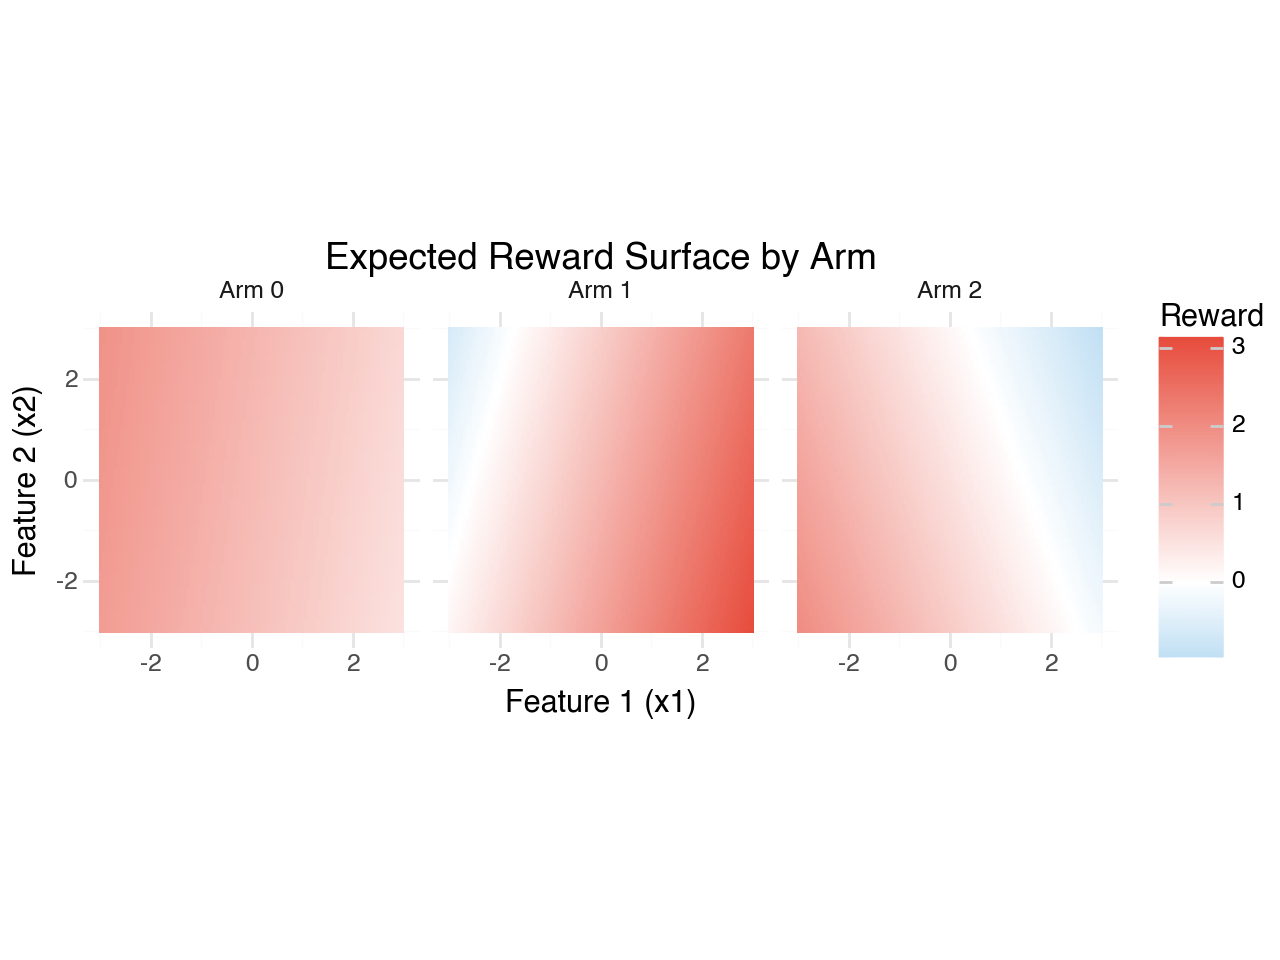

In [4]:
# Create dataframe for reward surfaces
df_rewards_list = []
for arm in range(n_arms):
    df_arm = pd.DataFrame({
        'x1': grid_points[:, 0],
        'x2': grid_points[:, 1],
        'reward': rewards_by_arm[:, arm],
        'arm': f'Arm {arm}'
    })
    df_rewards_list.append(df_arm)

df_rewards = pd.concat(df_rewards_list, ignore_index=True)

p_rewards = (ggplot(df_rewards, aes(x='x1', y='x2', fill='reward')) +
             geom_tile() +
             scale_fill_gradient2(low='#3498db', mid='white', high='#e74c3c', midpoint=0) +
             facet_wrap('~arm', ncol=3) +
             labs(title='Expected Reward Surface by Arm',
                  x='Feature 1 (x1)',
                  y='Feature 2 (x2)',
                  fill='Reward') +
             theme_minimal() +
             coord_fixed())

p_rewards

### 2.2 True Optimal Treatment Policy

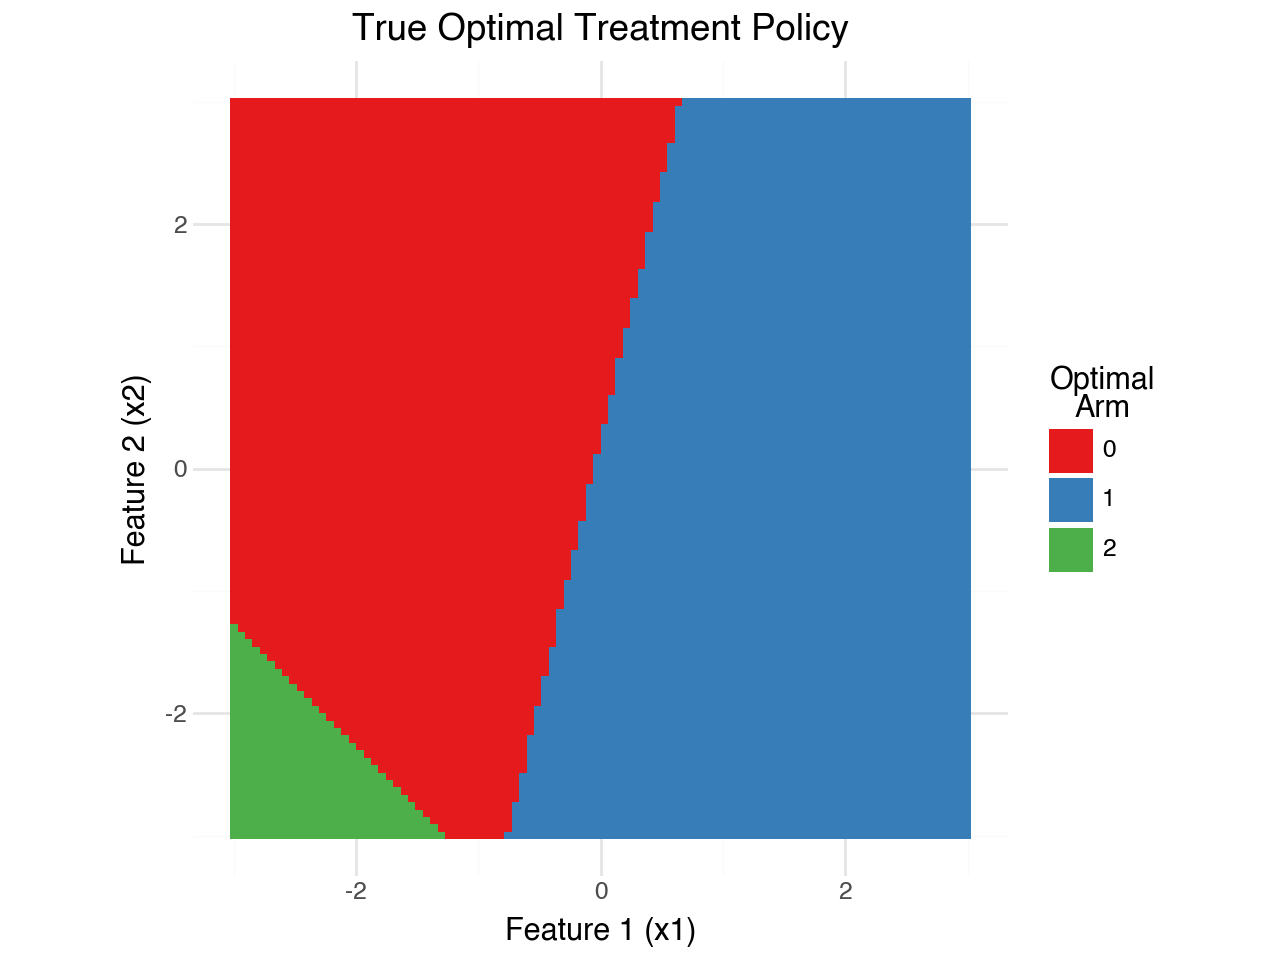

In [5]:
# Create dataframe for true optimal surface
df_true = pd.DataFrame({
    'x1': grid_points[:, 0],
    'x2': grid_points[:, 1],
    'optimal_arm': true_optimal_arms.astype(str)
})

p_true = (ggplot(df_true, aes(x='x1', y='x2', fill='optimal_arm')) +
          geom_tile() +
          scale_fill_brewer(type='qual', palette='Set1') +
          labs(title='True Optimal Treatment Policy',
               x='Feature 1 (x1)',
               y='Feature 2 (x2)',
               fill='Optimal\nArm') +
          theme_minimal() +
          coord_fixed())

p_true

### 2.3 Optimal Reward Surface

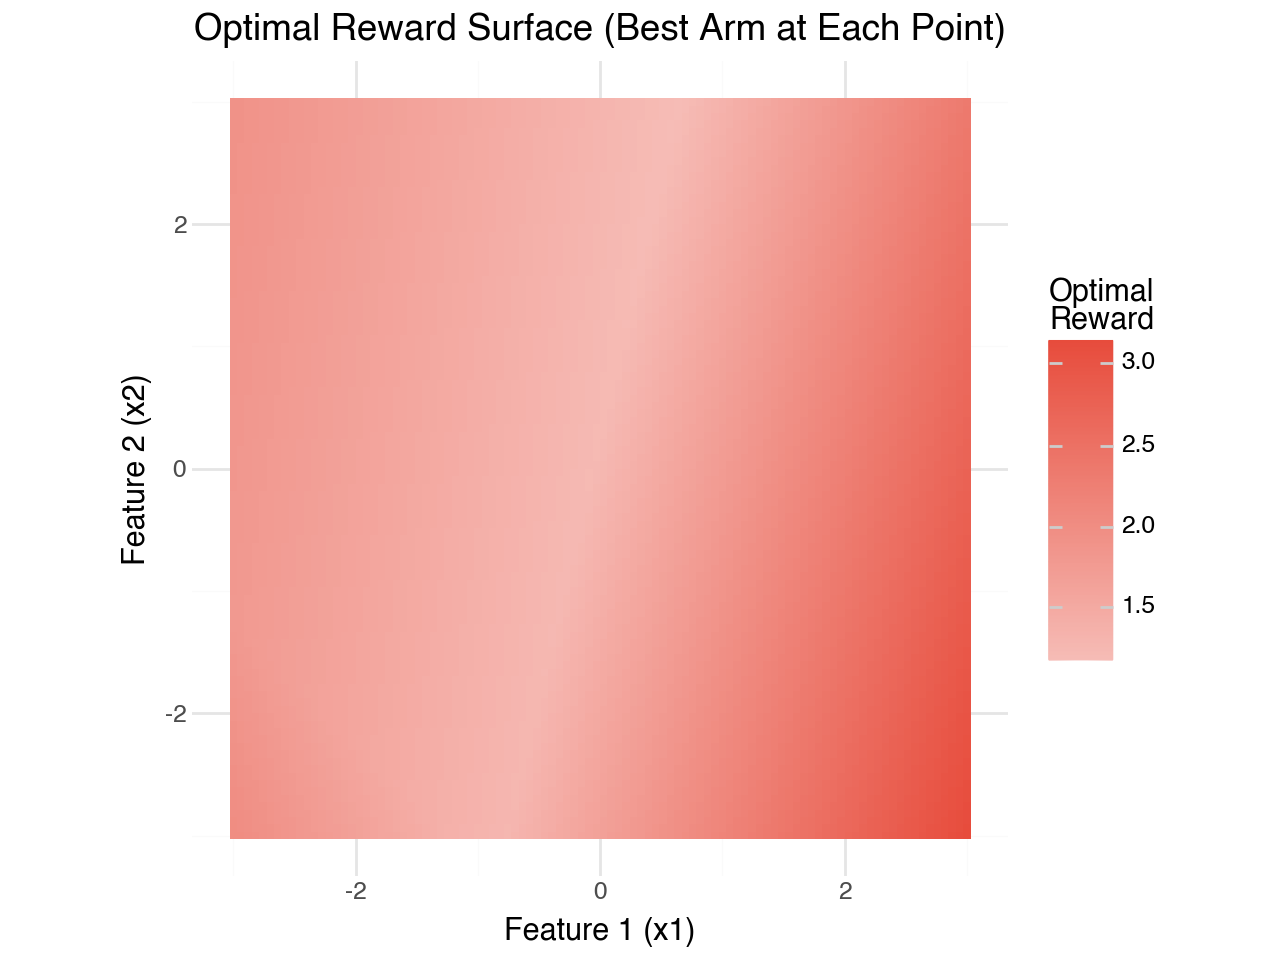

In [6]:
df_optimal_reward = pd.DataFrame({
    'x1': grid_points[:, 0],
    'x2': grid_points[:, 1],
    'optimal_reward': optimal_rewards_grid
})

p_optimal_reward = (ggplot(df_optimal_reward, aes(x='x1', y='x2', fill='optimal_reward')) +
                    geom_tile() +
                    scale_fill_gradient2(low='#3498db', mid='white', high='#e74c3c', midpoint=0) +
                    labs(title='Optimal Reward Surface (Best Arm at Each Point)',
                         x='Feature 1 (x1)',
                         y='Feature 2 (x2)',
                         fill='Optimal\nReward') +
                    theme_minimal() +
                    coord_fixed())

p_optimal_reward

---
## 3. Policy Optimization: Policy Gradient vs Random Assignment

Now we train a policy gradient model online and compare it against pure randomization.

**Policy Gradient (without discount rate)**

Input: a differentiable policy parameterization $\pi(a \mid s, \theta)$
Algorithm parameter: step size $\alpha > 0$
Initialize policy parameter $\theta \in \mathbb{R}^{d'}$ (e.g., to $0$)

Loop forever (for each episode):

&emsp;Generate an episode $S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_T$, following $\pi(\cdot \mid \cdot, \theta)$

&emsp;Loop for each step of the episode $t = 0, 1, \ldots, T-1$:

&emsp;&emsp;$G \leftarrow \displaystyle\sum_{k=t+1}^{T} R_k$

&emsp;&emsp;$\theta \leftarrow \theta + \alpha G \nabla \ln \pi(A_t \mid S_t, \theta)$


In [7]:
# Initialize the policy gradient model
policy = PolicyGradient(n_features=n_features, n_actions=n_arms, lr=1e-2)

# Training configuration
n_rounds = 200
batch_size = 32

# Storage for results
pg_rewards = []
pg_regrets = []
random_rewards = []
random_regrets = []
pg_optimal_rates = []
random_optimal_rates = []

for round_idx in range(n_rounds):
    # Generate batch of contexts
    contexts = dgp.x(batch_size)

    # Get optimal arms and rewards for this batch
    optimal_arms = dgp.a_star(contexts)
    optimal_rewards = dgp.r_star(contexts)

    # --- Policy Gradient ---
    pg_actions, log_probs = policy.select_actions(contexts)
    pg_observed = dgp.r(pg_actions, contexts)
    policy.finish_batch(pg_observed, pg_actions, log_probs)

    pg_rewards.extend(pg_observed)
    pg_regrets.extend(optimal_rewards - pg_observed)
    pg_optimal_rates.append((pg_actions == optimal_arms).mean())

    # --- Random Assignment ---
    random_actions = np.random.randint(0, n_arms, size=batch_size)
    random_observed = dgp.r(random_actions, contexts)

    random_rewards.extend(random_observed)
    random_regrets.extend(optimal_rewards - random_observed)
    random_optimal_rates.append((random_actions == optimal_arms).mean())

# Convert to arrays
pg_rewards = np.array(pg_rewards)
pg_regrets = np.array(pg_regrets)
random_rewards = np.array(random_rewards)
random_regrets = np.array(random_regrets)
n_samples = len(pg_rewards)

print(f"Training complete: {n_rounds} rounds, {n_samples} total samples")

Training complete: 200 rounds, 6400 total samples


### 3.1 Learned Policy vs True Optimal Policy

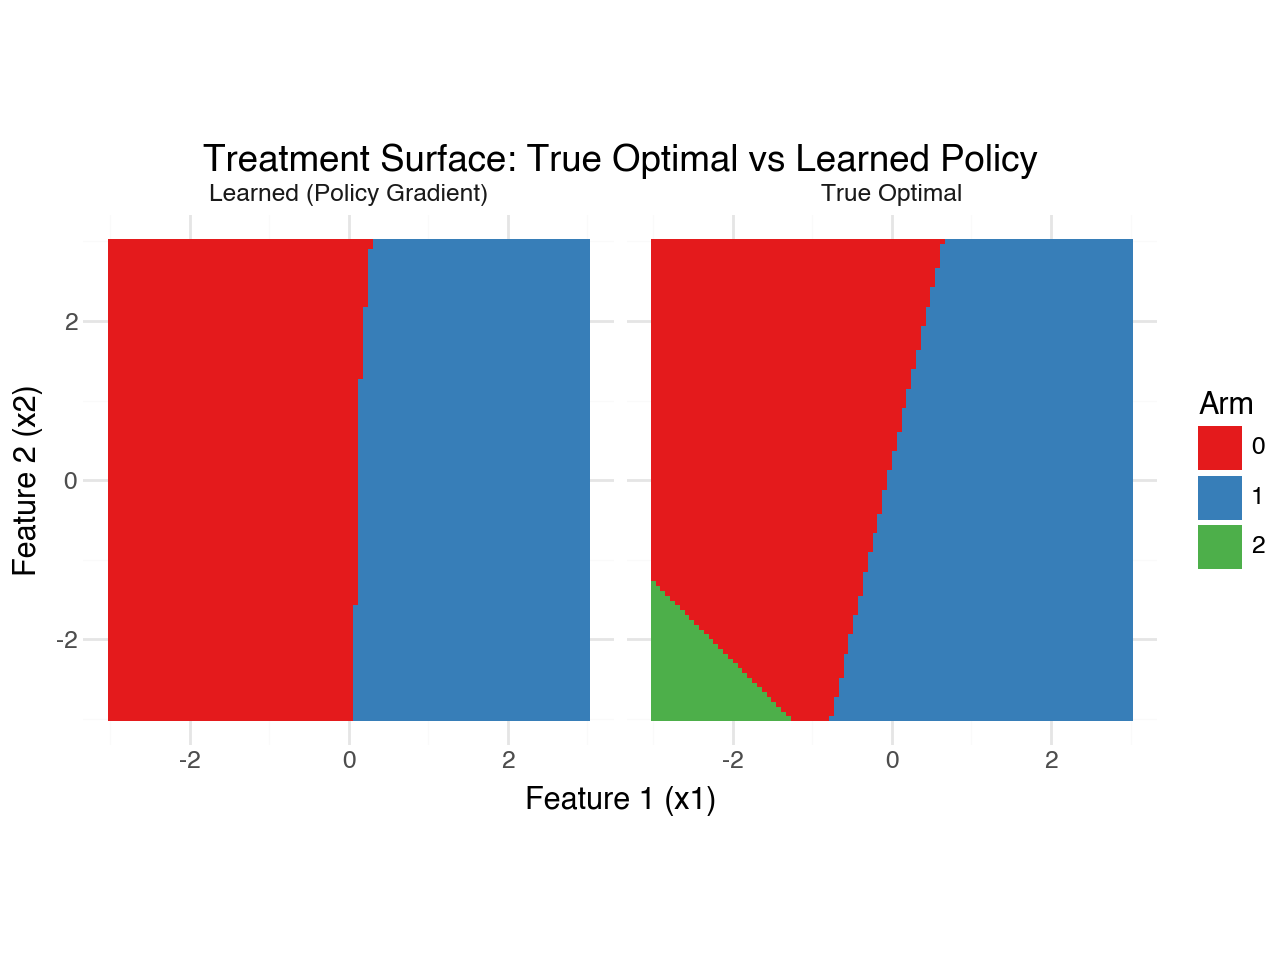

In [8]:
# Get learned policy's predictions on the grid
with torch.no_grad():
    log_probs = policy.forward(torch.from_numpy(grid_points).float())
    learned_arms = torch.argmax(log_probs, dim=1).numpy()

# Create comparison dataframe
df_true_comp = pd.DataFrame({
    'x1': grid_points[:, 0],
    'x2': grid_points[:, 1],
    'arm': true_optimal_arms.astype(str),
    'policy': 'True Optimal'
})

df_learned_comp = pd.DataFrame({
    'x1': grid_points[:, 0],
    'x2': grid_points[:, 1],
    'arm': learned_arms.astype(str),
    'policy': 'Learned (Policy Gradient)'
})

df_comparison = pd.concat([df_true_comp, df_learned_comp], ignore_index=True)

p_comparison = (ggplot(df_comparison, aes(x='x1', y='x2', fill='arm')) +
                geom_tile() +
                scale_fill_brewer(type='qual', palette='Set1') +
                facet_wrap('~policy') +
                labs(title='Treatment Surface: True Optimal vs Learned Policy',
                     x='Feature 1 (x1)',
                     y='Feature 2 (x2)',
                     fill='Arm') +
                theme_minimal() +
                coord_fixed())

p_comparison

### 3.2 Policy Agreement Map

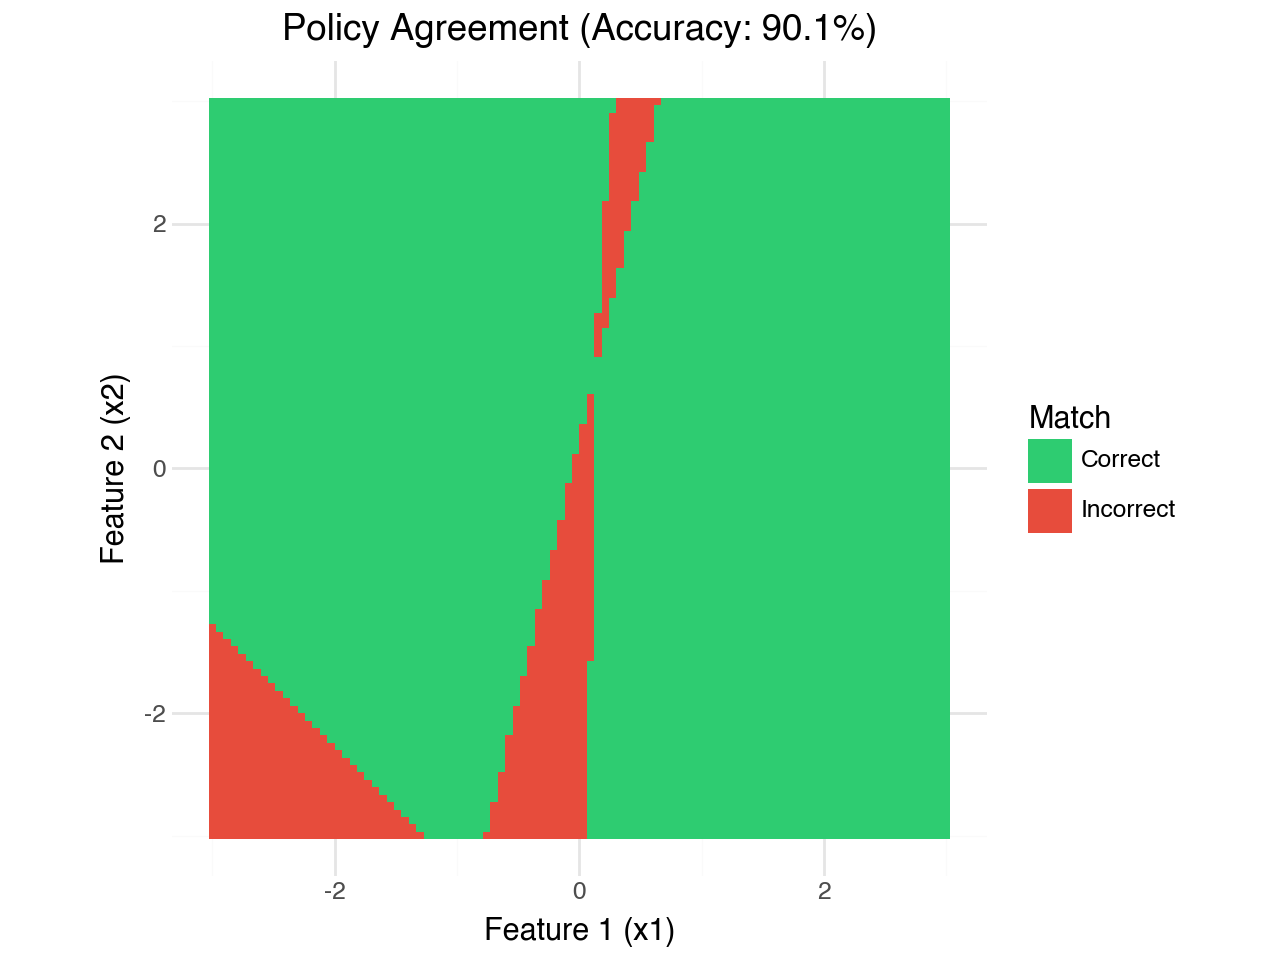

In [9]:
# Where does the learned policy match the true optimal?
agreement = (true_optimal_arms == learned_arms)
accuracy = agreement.mean() * 100

df_agreement = pd.DataFrame({
    'x1': grid_points[:, 0],
    'x2': grid_points[:, 1],
    'matches': np.where(agreement, 'Correct', 'Incorrect')
})

p_agreement = (ggplot(df_agreement, aes(x='x1', y='x2', fill='matches')) +
               geom_tile() +
               scale_fill_manual(values={'Correct': '#2ecc71', 'Incorrect': '#e74c3c'}) +
               labs(title=f'Policy Agreement (Accuracy: {accuracy:.1f}%)',
                    x='Feature 1 (x1)',
                    y='Feature 2 (x2)',
                    fill='Match') +
               theme_minimal() +
               coord_fixed())

p_agreement

---
## 4. Regret Analysis

Regret measures the difference between the optimal reward and the observed reward. We analyze both instantaneous and cumulative regret.

In [10]:
# Calculate cumulative regrets
pg_cumulative_regret = np.cumsum(pg_regrets)
random_cumulative_regret = np.cumsum(random_regrets)

report = performance_comparison_report(model1_rewards=pg_rewards,
                             model1_regrets=pg_regrets,
                             model1_cumulative_regret=pg_cumulative_regret,
                             model1_optimal_rates=pg_optimal_rates,
                             model2_rewards=random_rewards,
                             model2_regrets=random_regrets,
                             model2_cumulative_regret=random_cumulative_regret,
                             model2_optimal_rates=random_optimal_rates, )
print(report)

PERFORMANCE COMPARISON

Model 1:
  Mean reward: 1.4943
  Mean regret: 0.0258
  Total cumulative regret: 165.2091
  Final optimal arm rate: 93.75%

Model 2:
  Mean reward: 1.0121
  Mean regret: 0.5081
  Total cumulative regret: 3251.5376
  Mean optimal arm rate: 34.33%

Improvement:
  Regret reduction: 94.92%


In [11]:
regrets_dict = {
    'Policy Gradient': pg_regrets,
    'Random': random_regrets,
}

cumulative_regrets_dict = {
    'Policy Gradient': pg_cumulative_regret,
    'Random': random_cumulative_regret,
}
optimal_rate_dict = {
    'Policy Gradient': pg_optimal_rates,
    'Random': random_optimal_rates,
}

# Creates pg_rolling and random_rolling dataframes
window = 10
rolling_window = batch_size * window
pg_rolling = pd.Series(pg_regrets).rolling(window=rolling_window).mean().values
random_rolling = pd.Series(random_regrets).rolling(window=rolling_window).mean().values

# Create a dictionary for rolling_regret
rolling_regret_dict = {
    'Policy Gradient': pg_rolling,
    'Random': random_rolling,
}

p_cumulative_regret, p_optimal_rate, p_inst_regret, p_rolling = generate_comparison_plots(
    optimal_rate_dict=optimal_rate_dict,
    cumulative_regrets_dict=cumulative_regrets_dict,
    regrets_dict=regrets_dict,
    rolling_regret_dict=rolling_regret_dict,
    methods=['Policy Gradient', 'Random'],
    n_rounds=n_rounds,
    n_samples=n_samples,
    n_arms=n_arms,
    rolling_window=rolling_window, )

### 4.1 Cumulative Regret Over Time

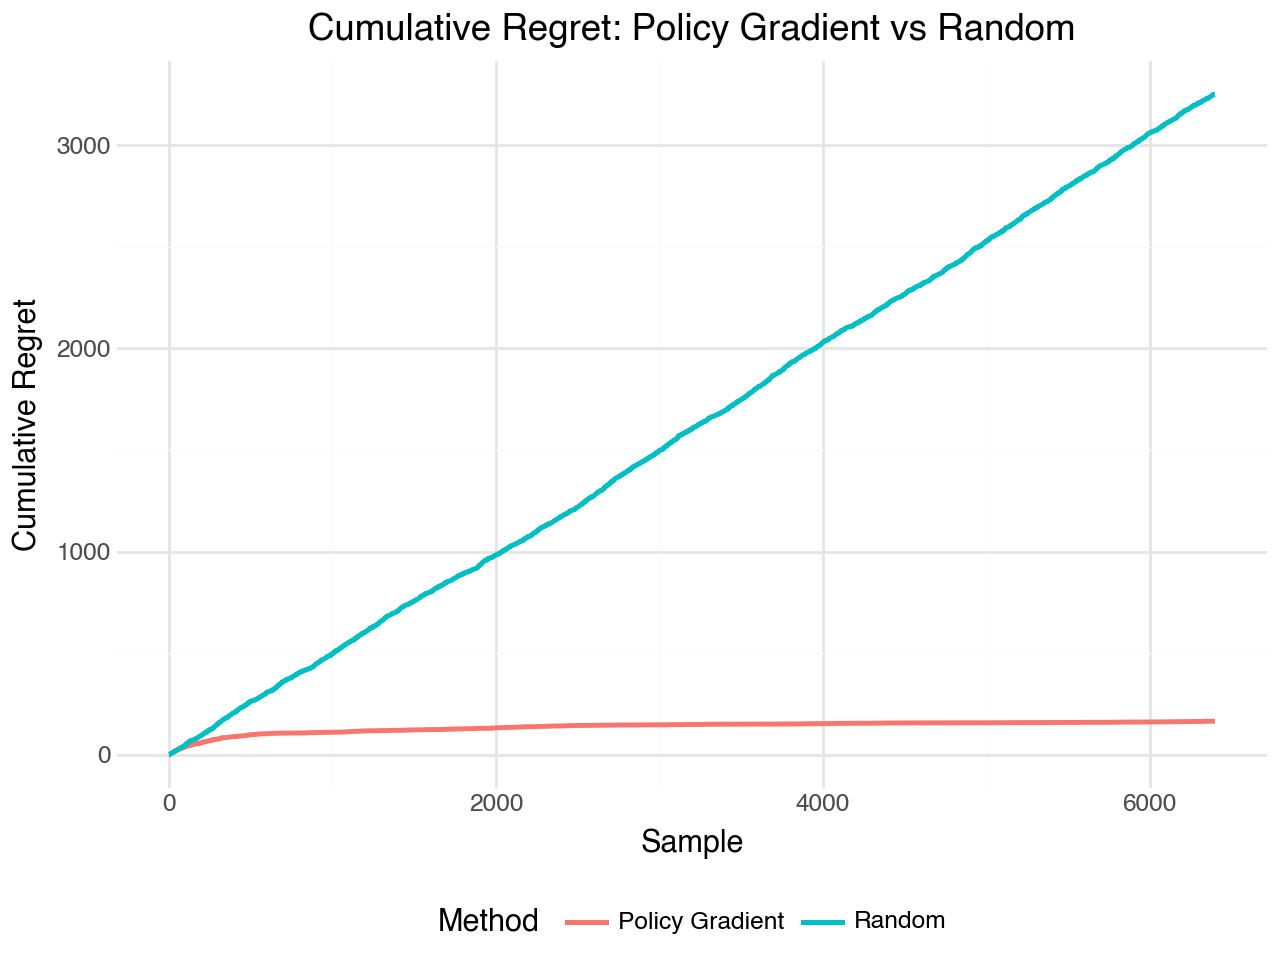

In [12]:
p_cumulative_regret

### 4.2 Instantaneous Regret Distribution

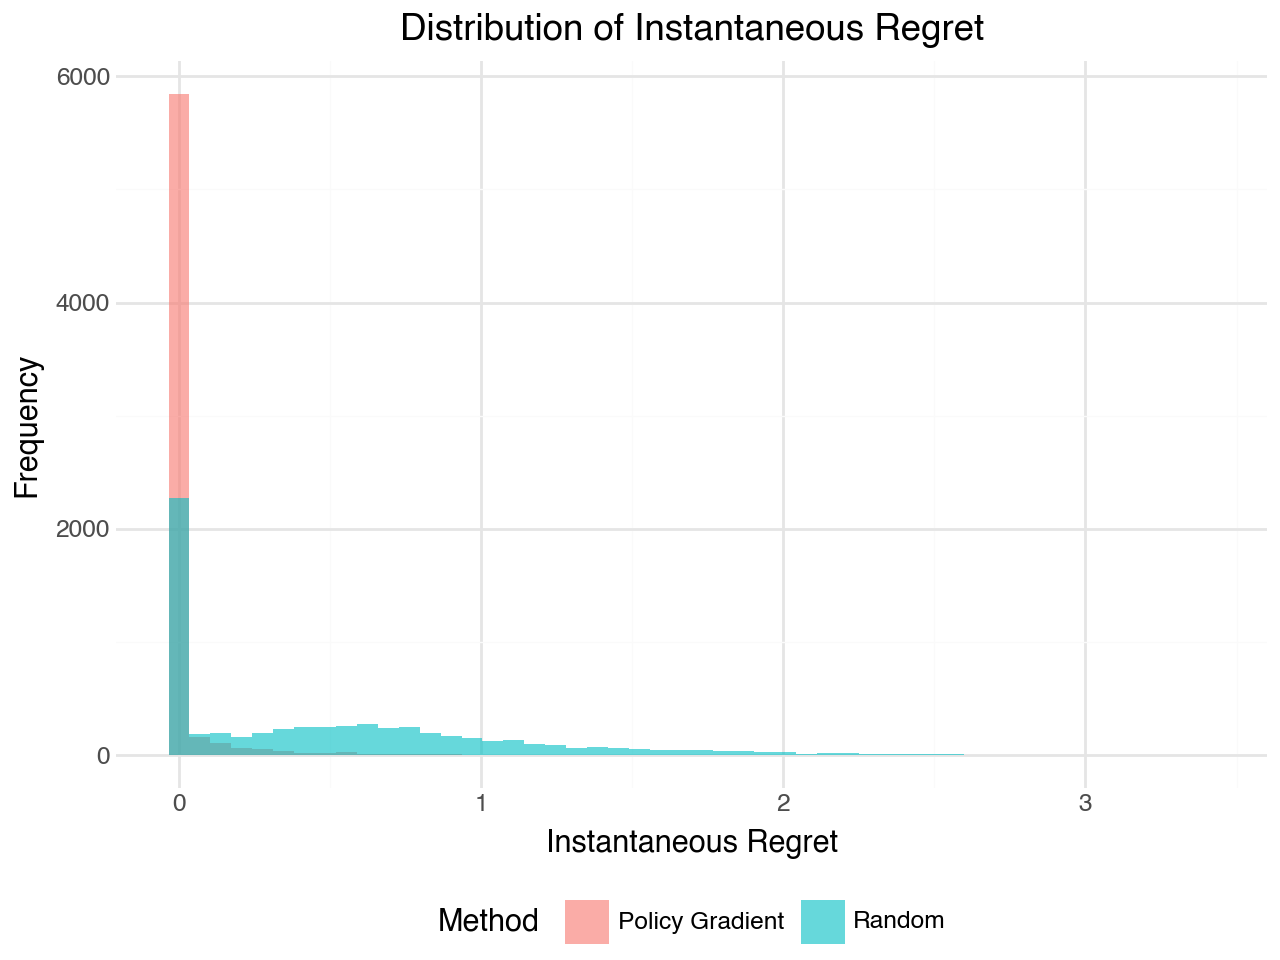

In [13]:
p_inst_regret

 ### 4.3 Optimal Arm Selection Rate Over Time


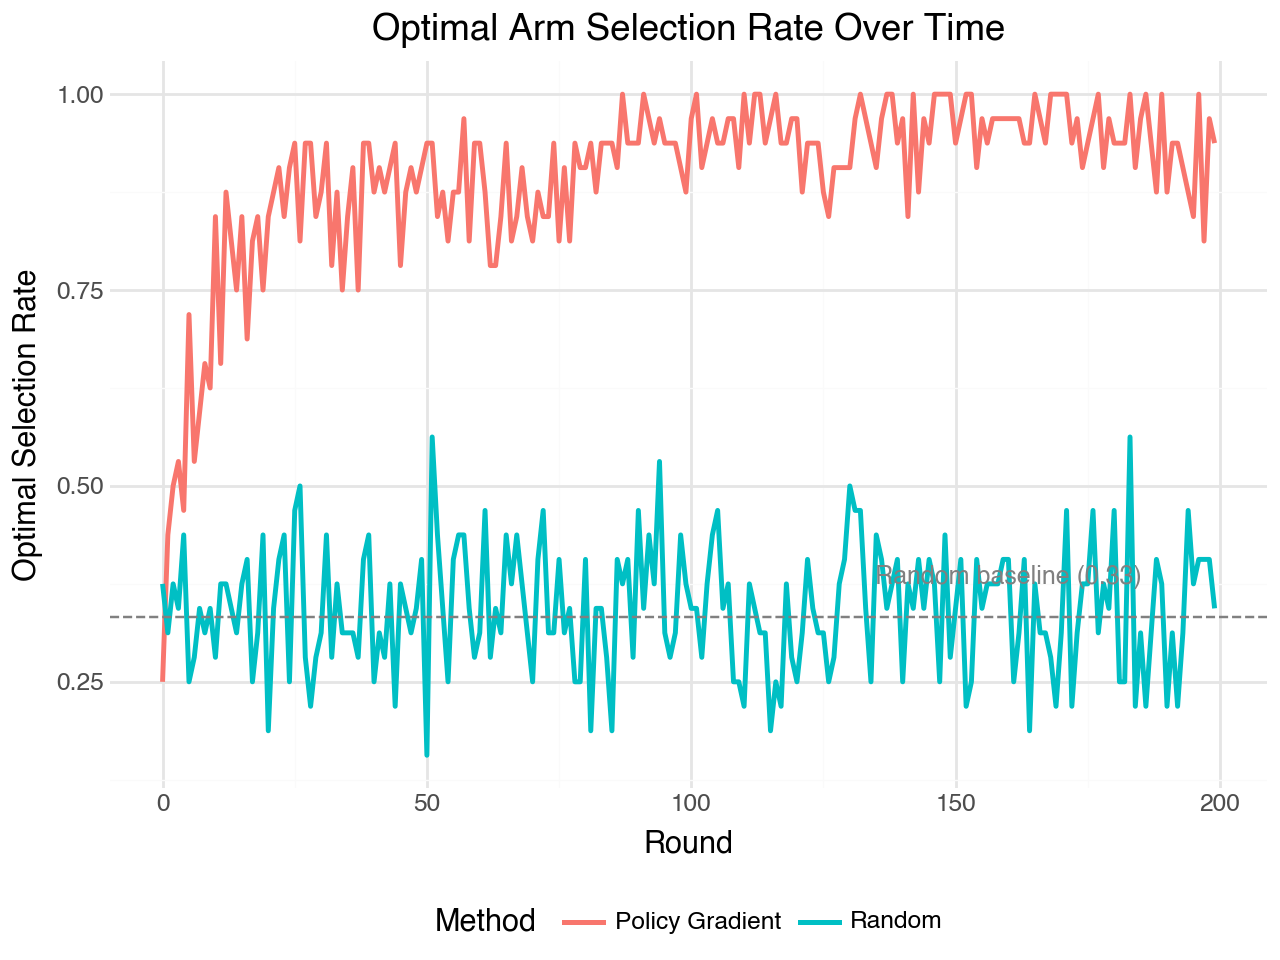

In [14]:
p_optimal_rate

### 4.4 Rolling Average Regret (Learning Curve)

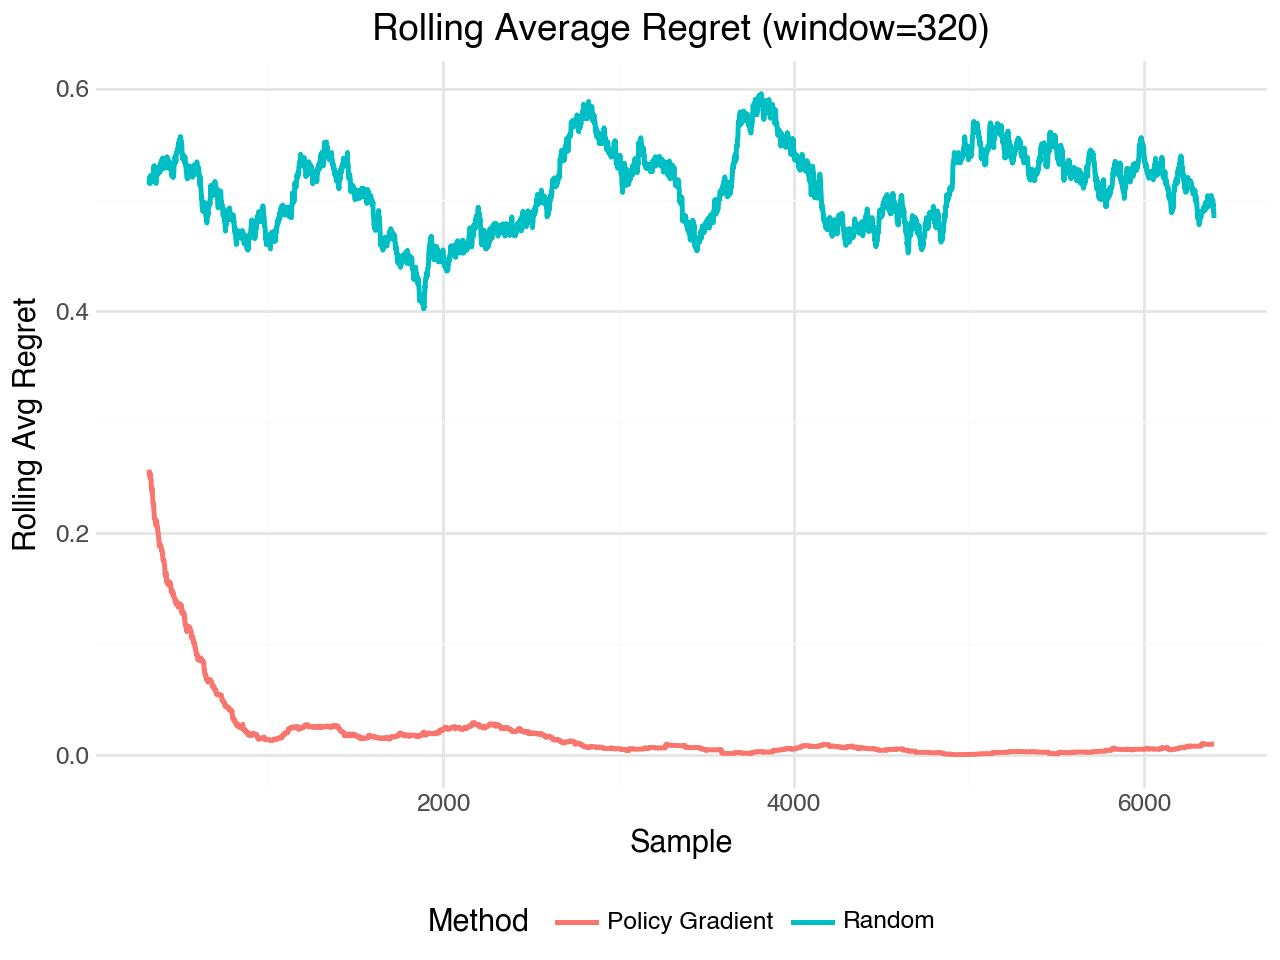

In [15]:
p_rolling

---
## 5. DQN: DQN vs Policy Gradient vs Random Assignment

Now we train a Deep Q-Network model online and compare it against pure randomization.

**Deep Q-Network for a single contextual bandit**

Input:
- action-value function $Q(s,a; \theta)$ with parameters $\theta$
- learning rate $\alpha$
- exploration schedule (e.g. $\varepsilon$-greedy)

Initialize network parameters $\theta$ randomly

---

For episode $= 1,2,\dots$:

&emsp;For $t = 1,2,\dots,T$:

&emsp;&emsp;Observe context (state) $s_t$

&emsp;&emsp;With probability $\varepsilon$ select a random action $a_t$

&emsp;&emsp;otherwise select
&emsp;&emsp;$a_t = \arg\max_a Q(s_t, a; \theta)$

&emsp;&emsp;Execute action $a_t$ and observe reward $r_t$

&emsp;&emsp;Compute the target
&emsp;&emsp;$y_t = r_t$

&emsp;&emsp;Perform a gradient descent step on the loss

&emsp;&emsp;$L(\theta) = (y_t - Q(s_t, a_t; \theta))^2$



In [17]:
# Storage for results
dqn = DQN(n_features=n_features, n_actions=n_arms, lr=1e-2, epsilon=0.1)
dqn_rewards = []
dqn_regrets = []
dqn_optimal_rates = []

for round_idx in range(n_rounds):
    # Generate batch of contexts
    contexts = dgp.x(batch_size)

    # Get optimal arms and rewards for this batch
    optimal_arms = dgp.a_star(contexts)
    optimal_rewards = dgp.r_star(contexts)

    # --- DQN ---
    dqn_actions = dqn.select_actions(contexts)
    dqn_observed = dgp.r(dqn_actions, contexts)

    # Update dqn
    dqn.finish_batch(rewards=dqn_observed, actions=dqn_actions, states=contexts)

    # Record dqn results
    dqn_rewards.extend(dqn_observed)
    dqn_regrets.extend(optimal_rewards - dqn_observed)
    dqn_optimal_rates.append((dqn_actions == optimal_arms).mean())

# Convert to arrays
dqn_rewards = np.array(dqn_rewards)
dqn_regrets = np.array(dqn_regrets)

n_samples = len(dqn_rewards)
print(f"Simulation complete: {n_rounds} rounds, {n_samples} total samples")

Simulation complete: 200 rounds, 6400 total samples


In [18]:
# Calculate cumulative regrets
dqn_cumulative_regret = np.cumsum(dqn_regrets)
random_cumulative_regret = np.cumsum(random_regrets)

report = performance_comparison_report(model1_rewards=dqn_rewards,
                             model1_regrets=dqn_regrets,
                             model1_optimal_rates=dqn_optimal_rates,
                             model1_cumulative_regret=dqn_cumulative_regret,
                             model2_rewards=random_rewards,
                             model2_regrets=random_regrets,
                             model2_optimal_rates=random_optimal_rates,
                             model2_cumulative_regret=random_cumulative_regret, )
print(report)

PERFORMANCE COMPARISON

Model 1:
  Mean reward: 1.4612
  Mean regret: 0.0625
  Total cumulative regret: 399.9128
  Final optimal arm rate: 96.88%

Model 2:
  Mean reward: 1.0121
  Mean regret: 0.5081
  Total cumulative regret: 3251.5376
  Mean optimal arm rate: 34.33%

Improvement:
  Regret reduction: 87.70%


In [19]:
regret_dict = {
    'DQN': dqn_regrets,
    'Policy Gradient': pg_regrets,
    'Random': random_regrets,
}

cumulative_regrets_dict = {
    'DQN': dqn_cumulative_regret,
    'Policy Gradient': pg_cumulative_regret,
    'Random': random_cumulative_regret,
}
optimal_rate_dict = {
    'DQN': dqn_optimal_rates,
    'Policy Gradient': pg_optimal_rates,
    'Random': random_optimal_rates,
}

# Creates pg_rolling and random_rolling dataframes
window = 10
rolling_window = batch_size * window
dqn_rolling = pd.Series(dqn_regrets).rolling(window=rolling_window).mean().values
pg_rolling = pd.Series(pg_regrets).rolling(window=rolling_window).mean().values
random_rolling = pd.Series(random_regrets).rolling(window=rolling_window).mean().values

# Create a dictionary for rolling_regret
rolling_regret_dict = {
    'DQN': dqn_rolling,
    'Policy Gradient': pg_rolling,
    'Random': random_rolling,
}



In [20]:
p_cumulative, p_optimal_rate, p_inst_regret, p_rolling = generate_comparison_plots(
    optimal_rate_dict=optimal_rate_dict,
    cumulative_regrets_dict=cumulative_regrets_dict,
    regrets_dict=regret_dict,
    rolling_regret_dict=rolling_regret_dict,
    methods=['DQN', 'Policy Gradient', 'Random'],
    n_rounds=n_rounds,
    n_samples=n_samples,
    n_arms=n_arms,
    rolling_window=rolling_window,)

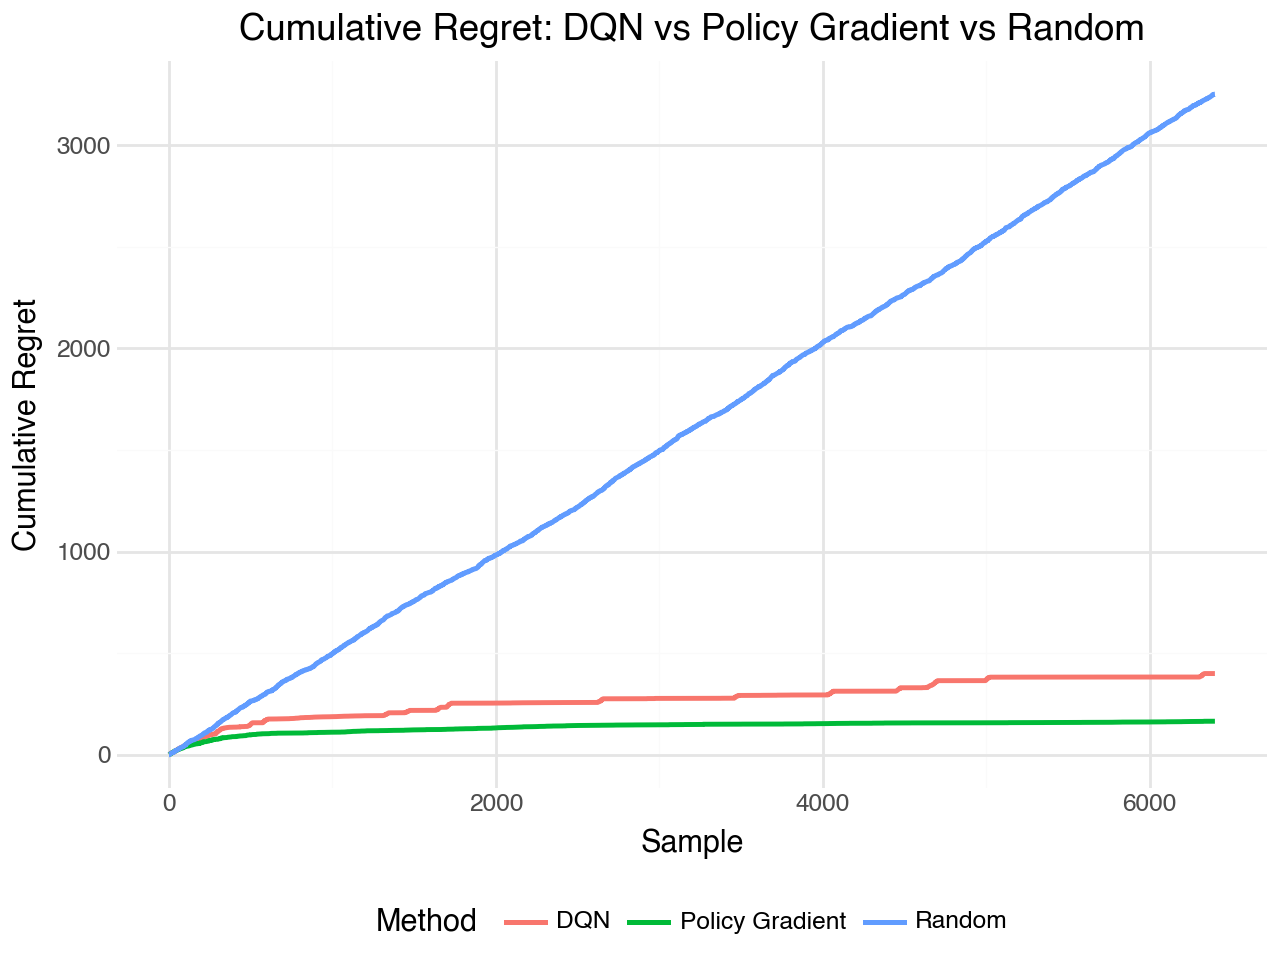

In [21]:
p_cumulative

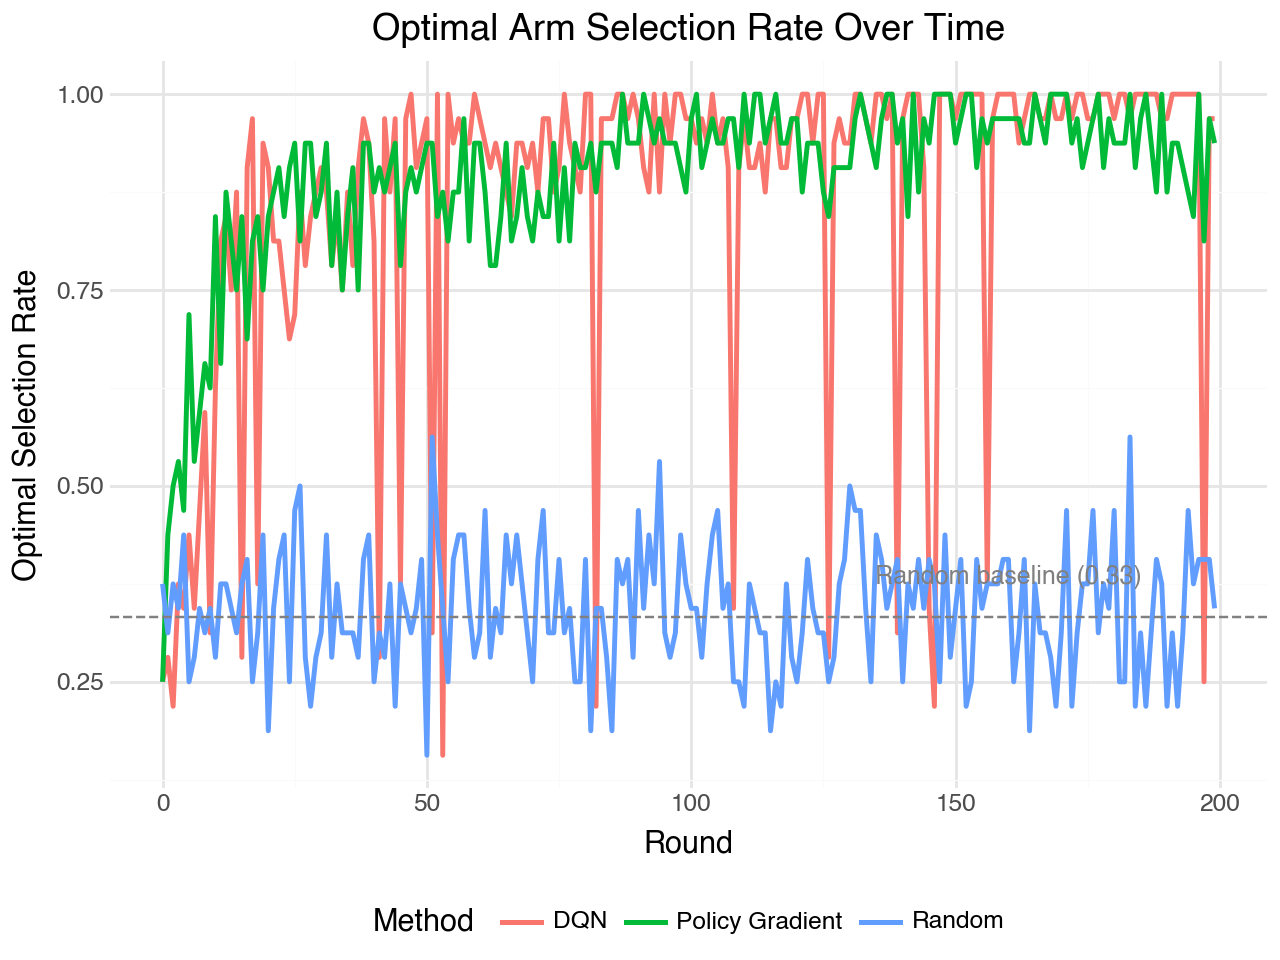

In [22]:
p_optimal_rate

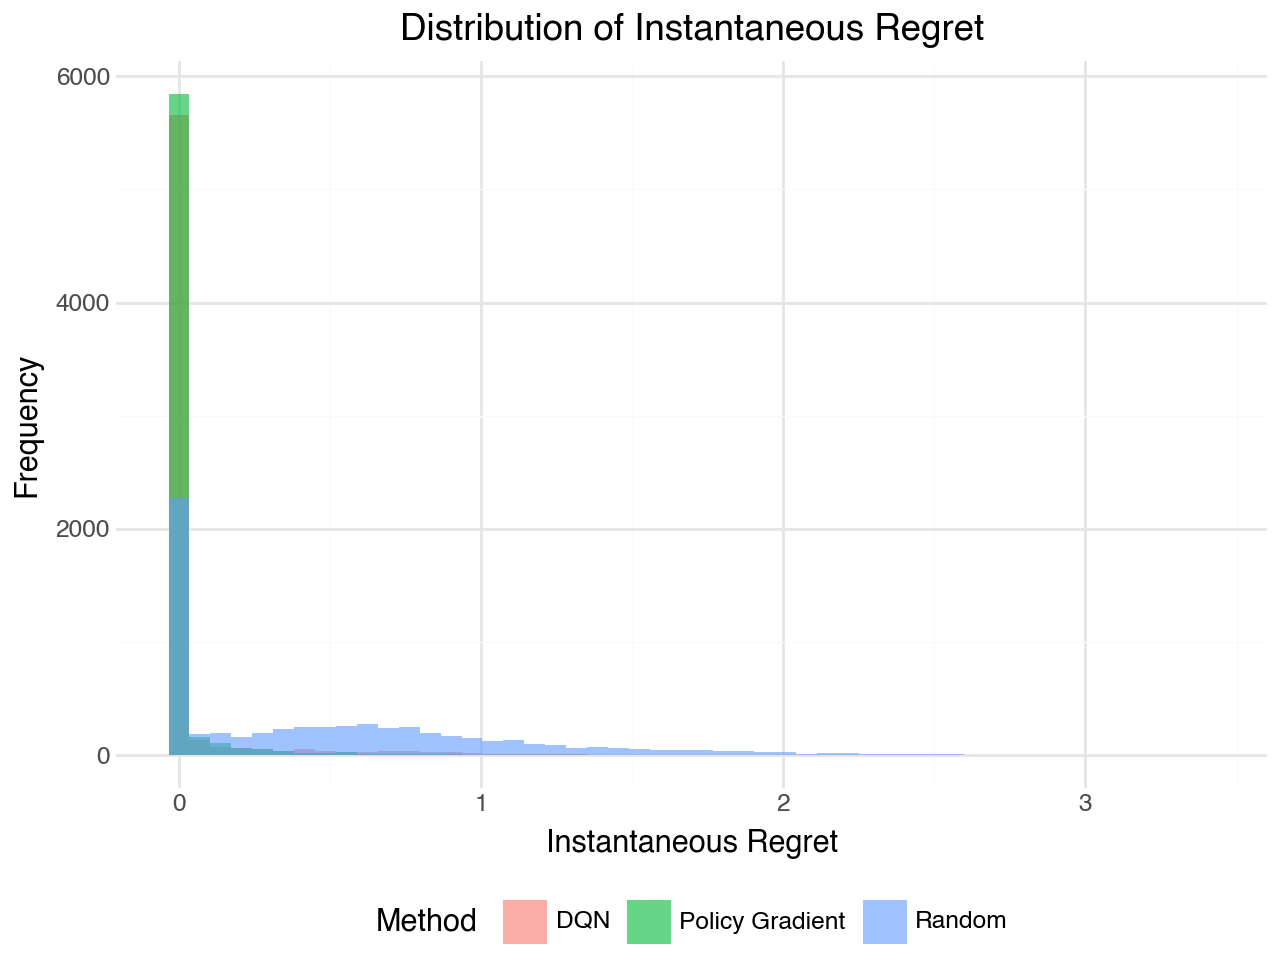

In [23]:
p_inst_regret

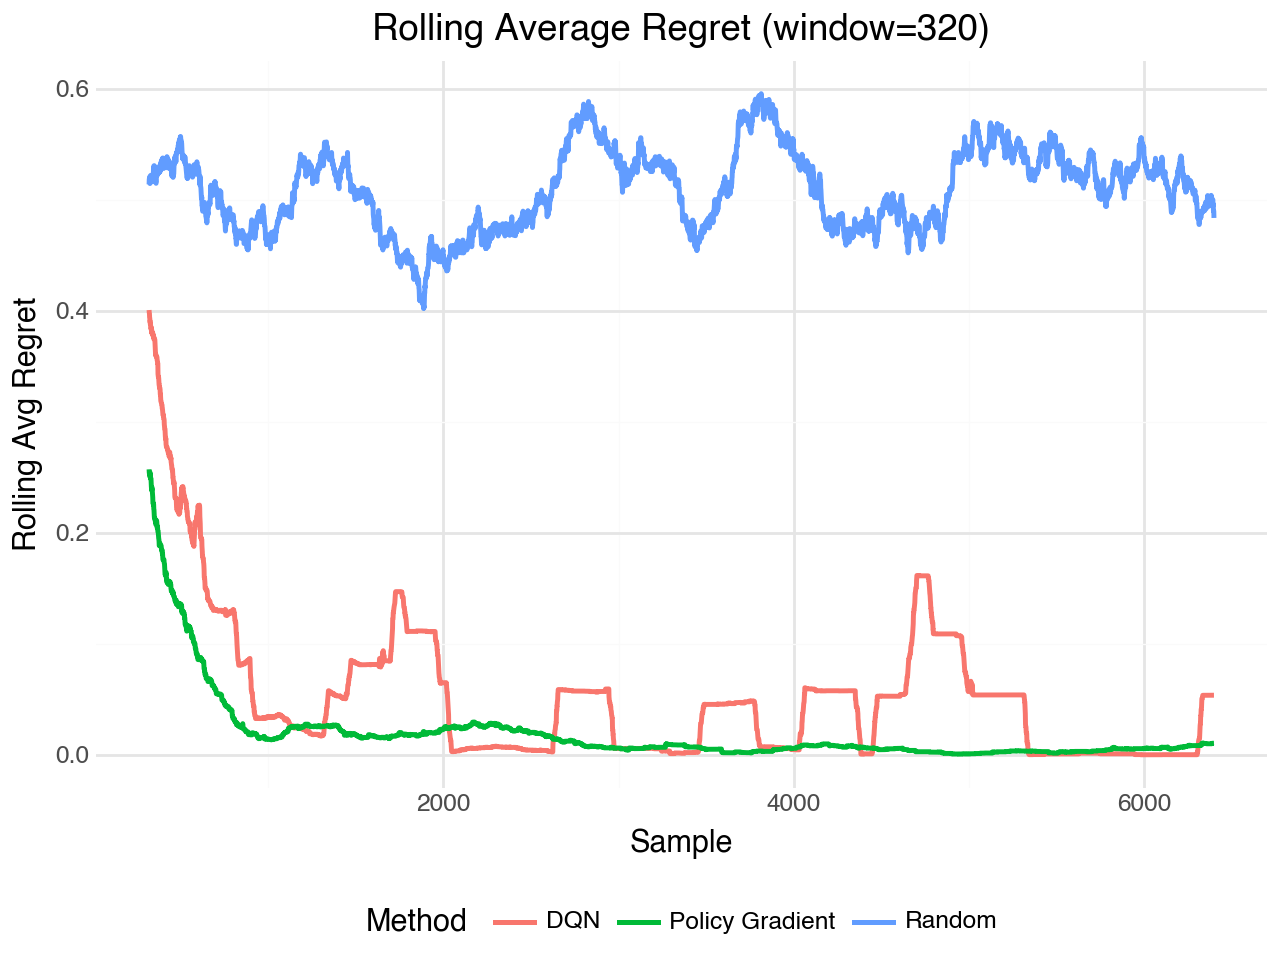

In [24]:
p_rolling

## 5. Actor-Critic: Actor-Critic vs Policy Gradient vs Random Assignment

Now we train a Actor-Critic model online and compare it against DQN, Policy Gradient and Random.

## Actor–Critic for a Contextual Bandit (No Discount Factor)

We maintain two function approximators:

- **Actor**: a parameterized policy $\pi(a \mid s, \theta)$ with parameters $\theta$
- **Critic**: a value (baseline) function $\hat{v}(s, w)$ with parameters $w$

Because this is a **contextual bandit**:

- There is **no next state** and no notion of future return.
- Each time step is independent: we see a context $s$, pick an action $a$, get an immediate reward $R$.
- The critic estimates the **expected reward** for a context, and the actor uses this to adjust the policy.

The **TD error** becomes simply:
\[
\delta = R - \hat{v}(s, w)
\]
This measures whether the received reward was higher or lower than the critic expected for that context.

---

### Contextual Bandit Actor–Critic Algorithm (No $\gamma$, No Next State)

Input:
- differentiable policy $\pi(a \mid s, \theta)$ (actor)
- differentiable value function $\hat{v}(s, w)$ (critic)
- step sizes $\alpha_\theta > 0$ (actor), $\alpha_w > 0$ (critic)

Initialize parameters $\theta, w$ (e.g., to zero)

For $t = 0, 1, 2, \ldots$:

&emsp;Observe context (state) $S_t$

&emsp;Sample action $A_t \sim \pi(\cdot \mid S_t, \theta)$

&emsp;Execute $A_t$ and observe reward $R_t$

&emsp;Compute the error signal (advantage estimate)
&emsp;$\delta_t = R_t - \hat{v}(S_t, w)$

&emsp;Update critic parameters
&emsp;$w \leftarrow w + \alpha_w \, \delta_t \, \nabla_w \hat{v}(S_t, w)$


&emsp;Update actor parameters
&emsp;$\theta \leftarrow \theta + \alpha_\theta \, \delta_t \, \nabla_\theta \ln \pi(A_t \mid S_t, \theta)$


&emsp;Continue to the next time step with a new context $S_{t+1}$ (independent of previous).



In [25]:
# Set an actor critic
actor_critic = ActorCritic(n_features=n_features, n_actions=n_arms, lr=1e-2)

# Storage for results
ac_rewards = []
ac_regrets = []
ac_optimal_rates = []

for round_idx in range(n_rounds):
    # Generate batch of contexts
    contexts = dgp.x(batch_size)

    # Get optimal arms and rewards for this batch
    optimal_arms = dgp.a_star(contexts)
    optimal_rewards = dgp.r_star(contexts)

    # --- Actor-Critic ---
    ac_actions, log_probs = actor_critic.select_actions(contexts)
    ac_observed = dgp.r(ac_actions, contexts)

    # Update actor-critic
    actor_critic.finish_batch(rewards=ac_observed, actions=ac_actions, states=contexts, log_probs=log_probs)

    # Record actor-critic results
    ac_rewards.extend(ac_observed)
    ac_regrets.extend(optimal_rewards - ac_observed)
    ac_optimal_rates.append((ac_actions == optimal_arms).mean())

# Convert to arrays
ac_rewards = np.array(ac_rewards)
ac_regrets = np.array(ac_regrets)

n_samples = len(ac_rewards)
print(f"Simulation complete: {n_rounds} rounds, {n_samples} total samples")

Simulation complete: 200 rounds, 6400 total samples


In [26]:
# Calculate cumulative regrets
ac_cumulative_regret = np.cumsum(ac_regrets)
random_cumulative_regret = np.cumsum(random_regrets)

report = performance_comparison_report(model1_rewards=ac_rewards,
                             model1_regrets=ac_regrets,
                             model1_optimal_rates=ac_optimal_rates,
                             model1_cumulative_regret=ac_cumulative_regret,
                             model2_rewards=random_rewards,
                             model2_regrets=random_regrets,
                             model2_optimal_rates=random_optimal_rates,
                             model2_cumulative_regret=random_cumulative_regret, )
print(report)

PERFORMANCE COMPARISON

Model 1:
  Mean reward: 1.5079
  Mean regret: 0.0188
  Total cumulative regret: 120.1324
  Final optimal arm rate: 100.00%

Model 2:
  Mean reward: 1.0121
  Mean regret: 0.5081
  Total cumulative regret: 3251.5376
  Mean optimal arm rate: 34.33%

Improvement:
  Regret reduction: 96.31%


In [27]:
regret_dict = {
    "Actor-Critic": ac_regrets,
    'DQN': dqn_regrets,
    'Policy Gradient': pg_regrets,
    'Random': random_regrets,
}

cumulative_regrets_dict = {
    "Actor-Critic": ac_cumulative_regret,
    'DQN': dqn_cumulative_regret,
    'Policy Gradient': pg_cumulative_regret,
    'Random': random_cumulative_regret,
}
optimal_rate_dict = {
    "Actor-Critic": ac_optimal_rates,
    'DQN': dqn_optimal_rates,
    'Policy Gradient': pg_optimal_rates,
    'Random': random_optimal_rates,
}

# Creates pg_rolling and random_rolling dataframes
window = 10
rolling_window = batch_size * window
ac_rolling = pd.Series(ac_regrets).rolling(window=rolling_window).mean().values
dqn_rolling = pd.Series(dqn_regrets).rolling(window=rolling_window).mean().values
pg_rolling = pd.Series(pg_regrets).rolling(window=rolling_window).mean().values
random_rolling = pd.Series(random_regrets).rolling(window=rolling_window).mean().values

# Create a dictionary for rolling_regret
rolling_regret_dict = {
    'Actor-Critic': ac_rolling,
    'DQN': dqn_rolling,
    'Policy Gradient': pg_rolling,
    'Random': random_rolling,
}



In [28]:
p_cumulative, p_optimal_rate, p_inst_regret, p_rolling = generate_comparison_plots(
    optimal_rate_dict=optimal_rate_dict,
    cumulative_regrets_dict=cumulative_regrets_dict,
    regrets_dict=regret_dict,
    rolling_regret_dict=rolling_regret_dict,
    methods=['Actor-Critic', 'DQN', 'Policy Gradient', 'Random'],
    n_rounds=n_rounds,
    n_samples=n_samples,
    n_arms=n_arms,
    rolling_window=rolling_window,)

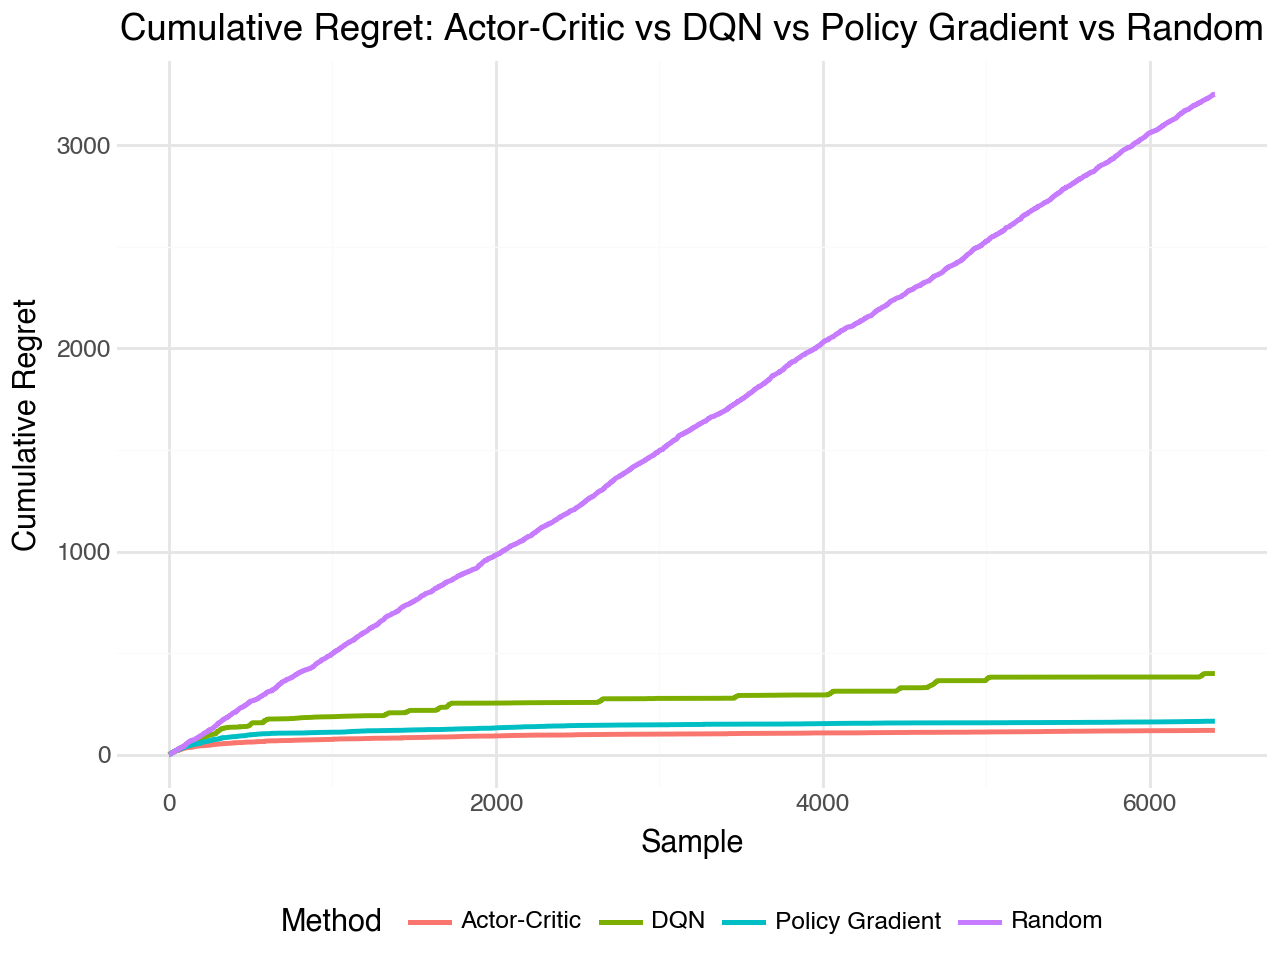

In [29]:
p_cumulative

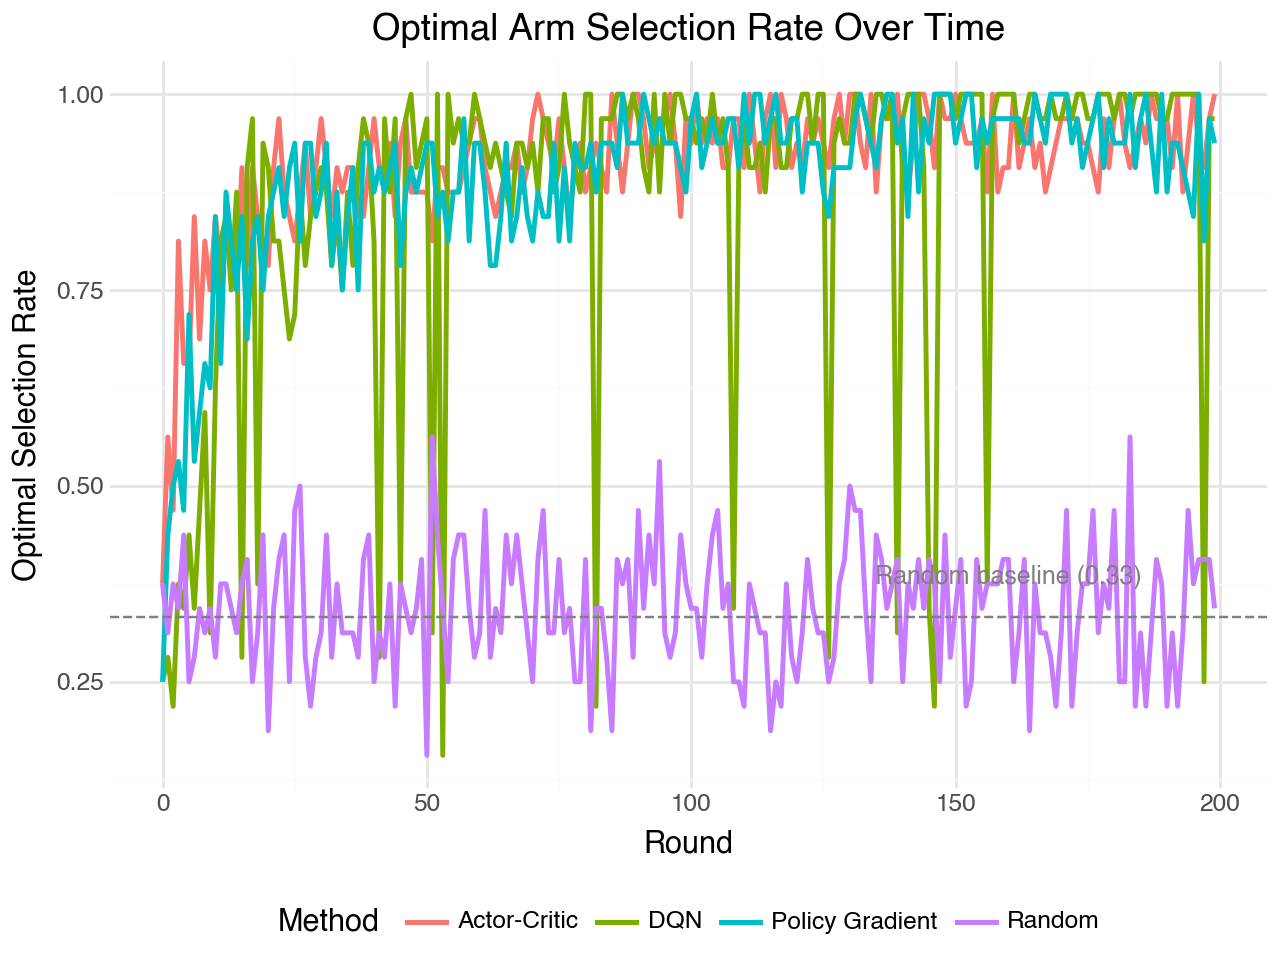

In [30]:
p_optimal_rate

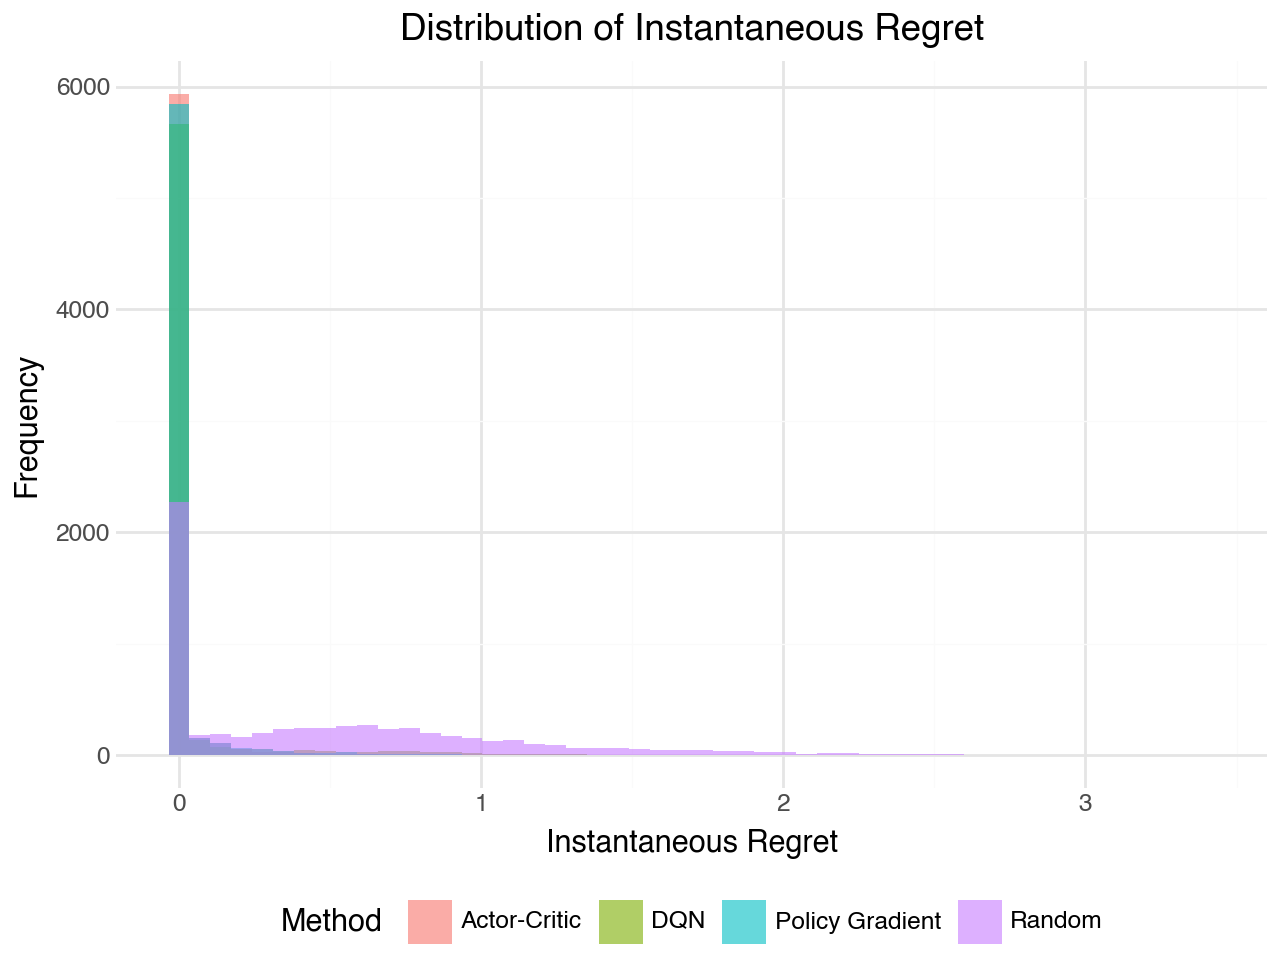

In [31]:
p_inst_regret

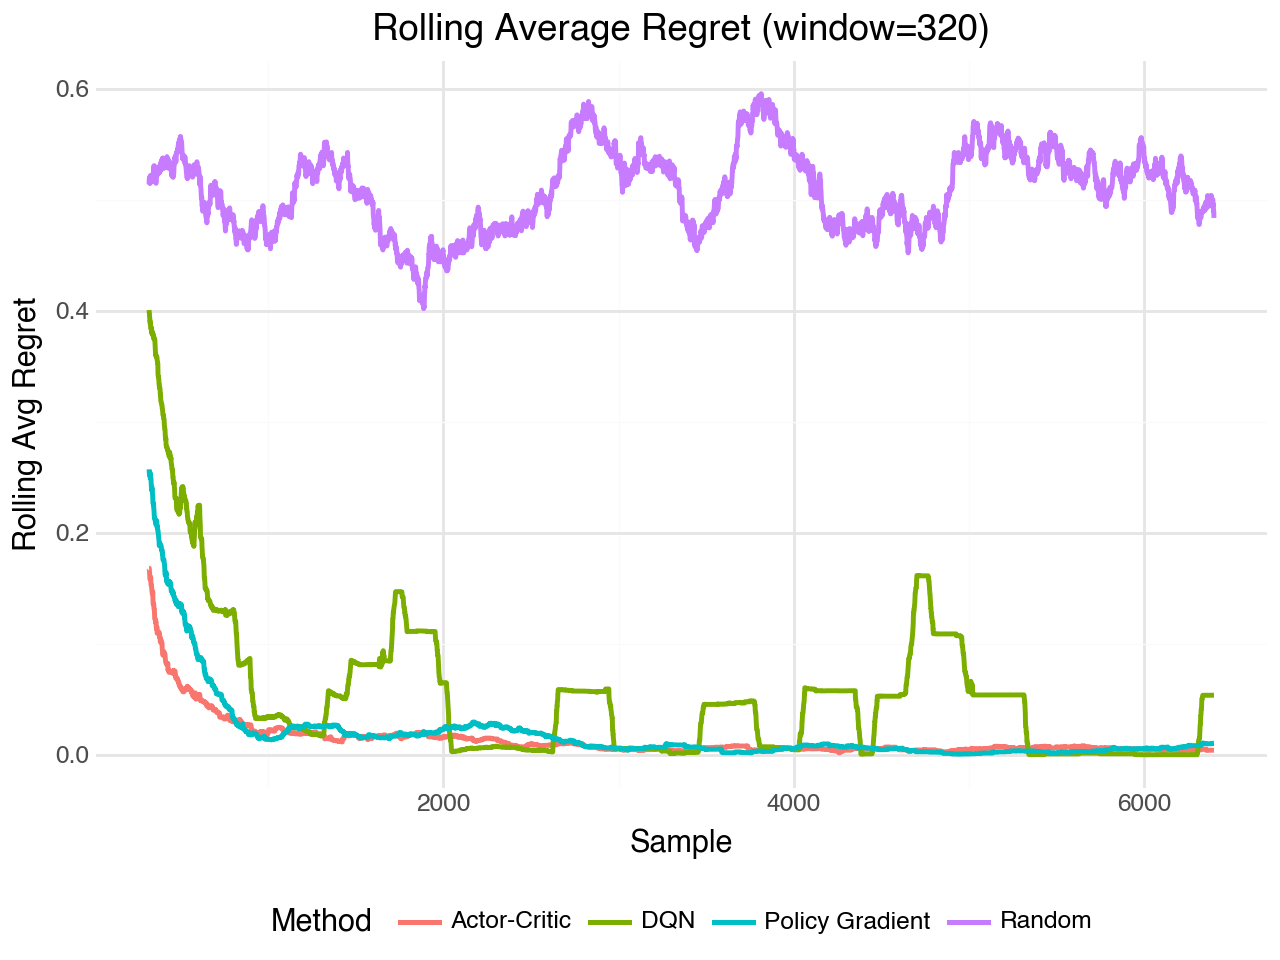

In [32]:
p_rolling